In [1]:
import torch
from torch import nn, optim

import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)

In [3]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [5]:
train_set = torchvision.datasets.MNIST(root='.',
                                      train=True,
                                      download=True,
                                      transform=transform)


In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

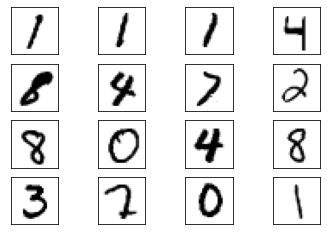

In [7]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [9]:
discriminator = Discriminator().to(device=device)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):        
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [11]:
generator = Generator().to(device=device)

In [12]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 4)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros(
            (batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 4)).to(device=device)

        # Training the generator        
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5576390027999878
Epoch: 0 Loss G.: 0.510384738445282
Epoch: 1 Loss D.: 0.0426107794046402
Epoch: 1 Loss G.: 5.604677200317383
Epoch: 2 Loss D.: 0.061573393642902374
Epoch: 2 Loss G.: 5.742495059967041
Epoch: 3 Loss D.: 0.022490713745355606
Epoch: 3 Loss G.: 11.059053421020508
Epoch: 4 Loss D.: 0.005776992067694664
Epoch: 4 Loss G.: 10.213907241821289
Epoch: 5 Loss D.: 0.017904365435242653
Epoch: 5 Loss G.: 8.495187759399414
Epoch: 6 Loss D.: 0.09296491742134094
Epoch: 6 Loss G.: 4.853506088256836
Epoch: 7 Loss D.: 0.19356754422187805
Epoch: 7 Loss G.: 2.5287981033325195
Epoch: 8 Loss D.: 0.19530543684959412
Epoch: 8 Loss G.: 1.8477904796600342
Epoch: 9 Loss D.: 0.32398784160614014
Epoch: 9 Loss G.: 2.404043197631836
Epoch: 10 Loss D.: 0.4802331328392029
Epoch: 10 Loss G.: 2.119551658630371
Epoch: 11 Loss D.: 0.4464423954486847
Epoch: 11 Loss G.: 1.5445611476898193
Epoch: 12 Loss D.: 0.519672155380249
Epoch: 12 Loss G.: 1.3875350952148438
Epoch: 13 Loss D.: 0.5622426

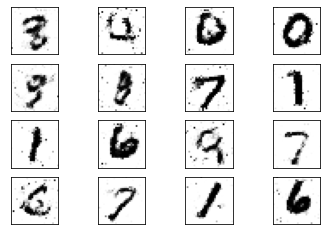

In [14]:
latent_space_samples = torch.randn(batch_size, 4).to(device=device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

In [15]:
torch.save(generator.state_dict(), "./generator_mnist_4.pt")
torch.save(discriminator.state_dict(), "./discriminator_mnist_4.pt")